<a href="https://colab.research.google.com/github/unnatihasija1/SpotifyClustering/blob/main/SpotifyClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install spotipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install hana_ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 31.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=ad3d19f82f895fadedaffac5e47d7c47d39f7a0094b10beb63011bb07d67d6d6
  Stored in directory: /root/.cache/pip/wheels/23/14/6e/4be5bfeeb027f4939a01764b48edd5996acf574b0913fe5243
Successfully built htmlmin


In [5]:
import pandas as pd
import spotipy
import os
import spotipy.util as util
import json
import hana_ml
from hana_ml.algorithms.pal import clustering
from hana_ml.algorithms.pal import partition
from hana_ml.docstore import create_collection_from_elements as jsoncollection
import hana_ml.dataframe as dataframe

In [6]:
from sklearn import manifold
import matplotlib.pyplot as plt


In [7]:
import numpy as np
import pandas as pd
import logging
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [8]:
from spotipy.oauth2 import SpotifyClientCredentials
from collections import defaultdict

In [9]:
cid = '0f5d88c5170c44f7b1d33d073ad1396b'
secret = 'e658f11d1ab147a482da2f6a846b70b9'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager
=
client_credentials_manager)


In [10]:
# setup hana connection
conn = dataframe.ConnectionContext(address='14a552ee-5028-4a45-933e-28455029a1c7.hna0.prod-eu10.hanacloud.ondemand.com', 
                                   port=443,
                                   user='UNNATI', 
                                   password='Hana1234',  
                                   encrypt='true'
                                   )

In [36]:
# Create the HANA dataframe in the structure of the specified table
df_remote = conn.table(table = 'TOPALL4', schema = 'BTP')
df = df_remote.head(10).collect()
df_remote.dtypes()
df_remote.describe().collect()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   TRACK ID      10 non-null     object
 1   TRACK NAME    10 non-null     object
 2   ALBUM NAME    10 non-null     object
 3   IMAGE         10 non-null     object
 4   DANCEABILITY  10 non-null     object
 5   SPEECHINESS   10 non-null     object
 6   ENERGY        10 non-null     object
 7   POPULARITY    10 non-null     int64 
 8   LIVENESS      10 non-null     object
dtypes: int64(1), object(8)
memory usage: 848.0+ bytes


In [37]:
df_unique = df_remote.drop_duplicates(subset=['TRACK ID'])
print(df_unique.shape)
#print(df_unique.head(10).collect())
train, test, valid = partition.train_test_val_split(data = df_unique, training_percentage = 0.7, 
                                                    testing_percentage = 0.3, validation_percentage = 0)
print(train, test, valid)

[321, 9]
<hana_ml.dataframe.DataFrame object at 0x7f49cb23d8b0> <hana_ml.dataframe.DataFrame object at 0x7f49cb23d9d0> <hana_ml.dataframe.DataFrame object at 0x7f4a071fadf0>


In [38]:
training_data = df_unique.collect().sample(frac=0.8, random_state=25)
testing_data = df_unique.collect().drop(training_data.index)

#training_df = dataframe.create_dataframe_from_pandas(connection_context=conn, pandas_df=training_data, table_name=TOPALL2)
#testing_df = dataframe.create_dataframe_from_pandas(connection_context=conn, pandas_df=testing_data)

#ratio = 0.75
#train_size = int(df_unique.shape[0]*ratio)
#print(df_unique)
#training_data = df_unique[0:train_size]
#testing_data = df_unique[train_size:]
features =  ['DANCEABILITY', 'ENERGY', 'LIVENESS', 'SPEECHINESS'] 
#label = ['POPULARITY']

In [39]:
kmeans = clustering.KMeans(thread_ratio=0.2, n_clusters=3, distance_level='euclidean',  #cosine
                           max_iter=10, tol=1.0E-6, category_weights=0.5, normalization='min_max')
predictions = kmeans.fit_predict(train, 'TRACK ID', features)
p = predictions.collect()
print(p)
res=kmeans.fit(test, 'TRACK ID', features)

                   TRACK ID  CLUSTER_ID  DISTANCE  SLIGHT_SILHOUETTE
0    7F0MuIk5glqtowCUjbn9es           1  0.269656           0.129448
1    5w8dx6u3KGawHWZAJoqyKM           0  0.290505           0.234145
2    7Els4IIFYa4P4RxBkZkxdd           1  0.137673           0.704964
3    0JXXNGljqupsJaZsgSbMZV           1  0.207842           0.113609
4    08Isz2ETWSBhvIl8UpKYsp           0  0.302997           0.047883
..                      ...         ...       ...                ...
220  3rb0tMq42WfggucPm0HHkA           1  0.177088           0.562025
221  02MWAaffLxlfxAUY7c5dvx           0  0.195092           0.376902
222  0zlGnseLGzRIBA0TJcb3Bo           1  0.136448           0.699874
223  1smFN2CLqGROu0J0UyvDfL           1  0.259449           0.581533
224  4uUG5RXrOk84mYEfFvj3cK           2  0.465905           0.108752

[225 rows x 4 columns]


In [41]:
y = predictions.collect()[["CLUSTER_ID"]].astype(int)
#print(y)
m = {-1: '#999999', 0:'#377eb8',1:'#ff7f00',2:'#4daf4a', 3: '#f781bf', 4: '#a65628', 5:'#984ea3', 6: '#e41a1c'}
colors = list(map(lambda x:m[x], y["CLUSTER_ID"]))

In [47]:
def plot_kmeans_results(data_set, features, predictions):

    class_colors = {0: '#999999', 1: '#377eb8', 2: '#ff7f00'}
    pred = predictions.collect()
    predictions_colors = [class_colors[p] for p in pred['CLUSTER_ID'].values]

    red = plt.Line2D(range(1), range(1), c='w', marker='o', markerfacecolor='#999999', label='1', markersize=10, alpha=0.9)
    blue = plt.Line2D(range(1), range(1), c='w', marker='o', markerfacecolor='#377eb8', label='2', markersize=10, alpha=0.9)
    black = plt.Line2D(range(1), range(1), c='w', marker='o', markerfacecolor='#ff7f00', label='3', markersize=10, alpha=0.9)

    for x, y in itertools.combinations(features, 2):
        plt.figure(figsize=(10,5))
        plt.scatter(data_set[[x]].collect(), data_set[[y]].collect(), c=predictions_colors, alpha=0.6, s=70)
        plt.grid()
        plt.xlabel(x, fontsize=15)
        plt.ylabel(y, fontsize=15)
        plt.tick_params(labelsize=15)
        plt.legend(handles=[red, blue, black])
        plt.show()

    %matplotlib notebook

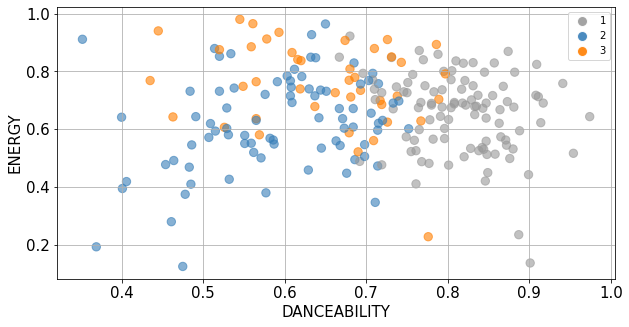

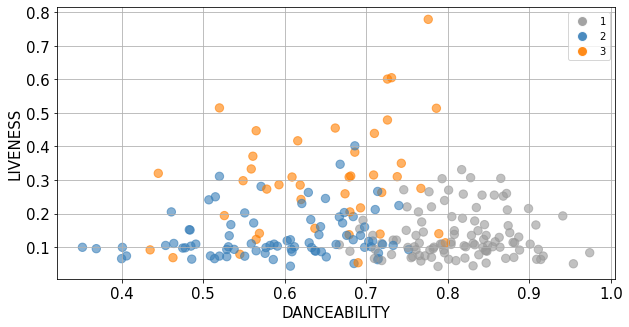

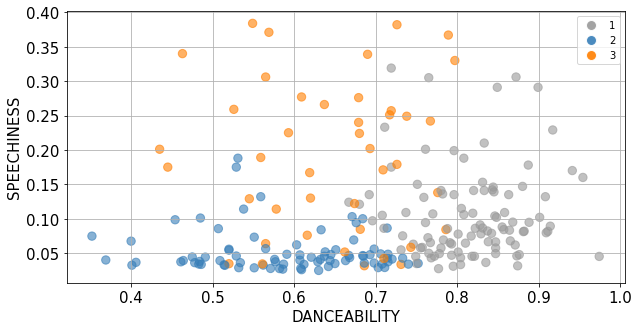

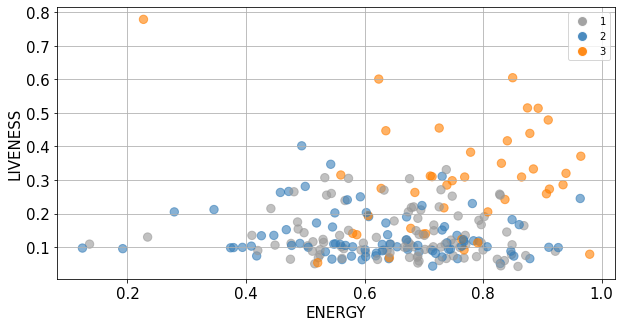

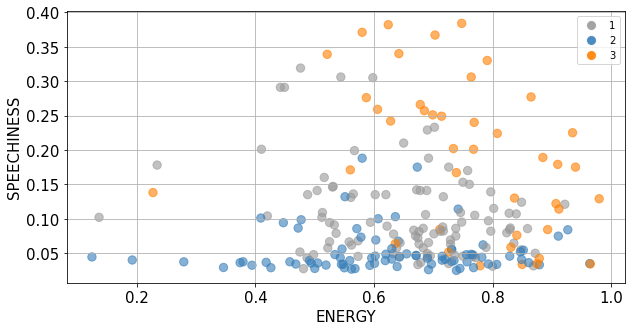

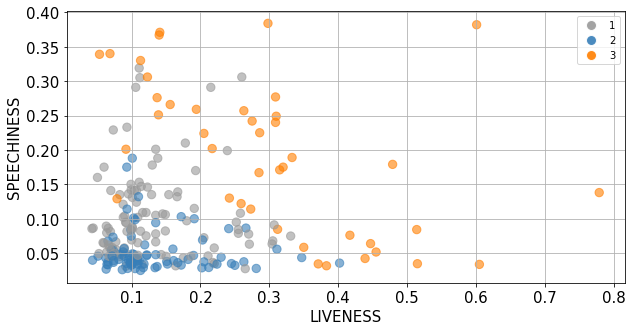

In [48]:
%matplotlib inline
plot_kmeans_results(train, features, predictions)